# Zonal averaged Surface CO2 upward flux

`cd project/seniorthesis/notebooks`

`conda list PyCO2SYS`

`pip install PyCO2SYS`

`pip install git+https://github.com/jbusecke/cmip6_preprocessing.git`

`mv *.png ../figures`

In [2]:
from scipy.io import loadmat
import xarray as xr
import xesmf as xe
from cmip6_preprocessing.preprocessing import combined_preprocessing
import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
from cmip6_preprocessing.postprocessing import combine_datasets
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
# import cmocean
import matplotlib.path as mpath
from cmip6_preprocessing.postprocessing import combine_datasets
from cmip6_preprocessing.postprocessing import merge_variables
from dask.diagnostics import ProgressBar
from xgcm import Grid
from xhistogram.xarray import histogram
import pandas as pd
from scipy.io import netcdf
import netCDF4 as nc


In [3]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

In [4]:
def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

## Area

In [5]:


variables = ['areacello']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Ofx'], 
             variable_id=variables,
             grid_label=['gr'],
              source_id=['GFDL-ESM4']
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dd_A = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [6]:
# pick first member in case there are multiple members
dd_A = combine_datasets(
    dd_A,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_A.keys())
# dd_new_new_gr

['GFDL-ESM4.gr.historical.Ofx']

## Get datasets and calculate variables

In [10]:
dd = {}
dd['UKESM1-0-LL.gn.historical.Omon'] = xr.open_mfdataset('UKESM1.nc').sel(y = slice(-90,-30))
dd['CanESM5-CanOE.gn.historical.Omon']= xr.open_mfdataset('CanESM5CanOE.nc').sel(y = slice(-90,-30))
dd['CNRM-ESM2-1.gn.historical.Omon']= xr.open_mfdataset('CNRM.nc').sel(y = slice(-90,-30))
dd['CanESM5.gn.historical.Omon']= xr.open_mfdataset('CanESM5.nc').sel(y = slice(-90,-30))
dd['IPSL-CM6A-LR.gn.historical.Omon']= xr.open_mfdataset('IPSL.nc').sel(y = slice(-90,-30))
dd['CESM2-WACCM.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM.nc').sel(y = slice(-90,-30))
dd['CESM2.gr.historical.Omon']= xr.open_mfdataset('CESM2.nc').sel(y = slice(-90,-30))
dd['CESM2-WACCM-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM-FV2.nc').sel(y = slice(-90,-30))
dd['GFDL-ESM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-ESM4.nc').sel(y = slice(-90,-30))
dd['CESM2-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-FV2.nc').sel(y = slice(-90,-30))
dd['GFDL-CM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-CM4.nc').sel(y = slice(-90,-30))
dd['MRI-ESM2-0.gr.historical.Omon']= xr.open_mfdataset('MRI-ESM2-0.nc').sel(y = slice(-90,-30))
# A = xr.open_mfdataset('AREA.nc')

In [11]:
for name, ds in dd.items():
    ds['p'] = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)*xr.ones_like(ds['talk']) # expand along time dimension
    ds['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], ds['p'])
    ds['sigma2'] = gsw.sigma2(ds['so'],ds['thetao'])
    ds['sigma0'] = gsw.sigma0(ds['so'],ds['thetao'])

In [45]:
for name, ds in dd.items():
    conversion =  1e6/1035
    results = pyco2.sys(par1=ds['talk']*conversion,par2=ds['dissic']*conversion,par1_type=1,par2_type=2,
                        pressure_out=0, temperature_out = ds['thetao'], pressure = ds['p'], 
                        temperature = ds['insitutemp'])
    # ds['PCO2'] = results['pCO2_out']
    # ppco2 = ds.dissic.copy(data=results['pCO2_out'])
    ds['PCO2'] = ds.dissic.copy(data=results['pCO2_out'])



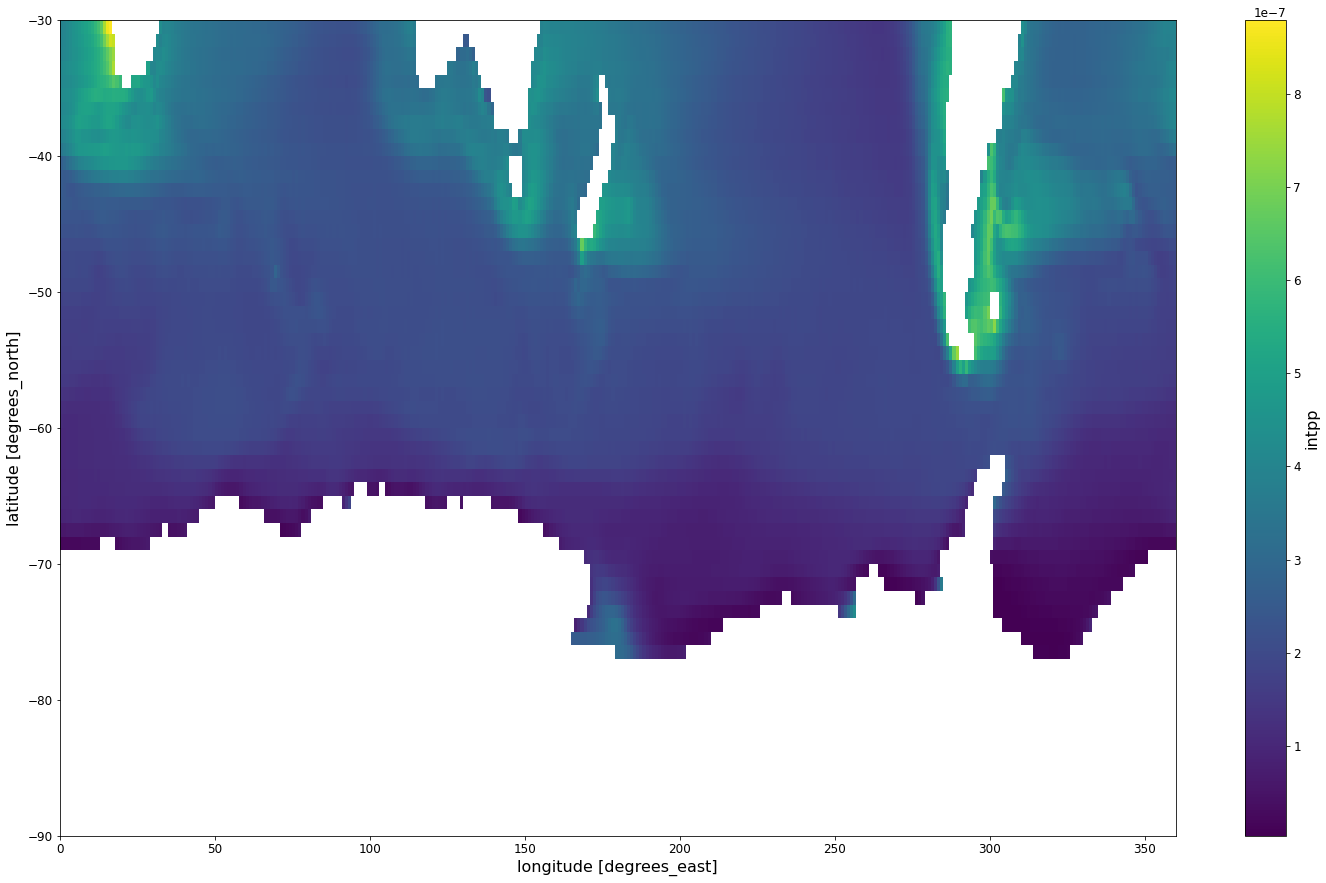

In [48]:
dd['CESM2-FV2.gr.historical.Omon'].intpp.plot()

In [58]:
for name, ds in dd.items():
    conv_intpp = 3.1536e7 * 12
    present = ds.data_vars
    if 'intpp' in present:
        ds['intpp'] = ds['intpp']*conv_intpp

In [61]:
for name, ds in dd.items():
    # ds = ds.PCO2
    # if name == 'CESM2-WACCM.gr.historical.Omon' or name == 'CESM2.gr.historical.Omon' or name == 'CESM2-FV2.gr.historical.Omon' or name == 'CESM2-WACCM-FV2.gr.historical.Omon' or name == 'GFDL-ESM4.gr.historical.Omon' or name == 'MRI-ESM2-0.gr.historical.Omon' :
    #     ML[name] = ds.sel(lev = dd_annual[name].mlotst, method = 'nearest')
    #     ML_JJA[name] = ds.sel(lev = dd_JJA[name].mlotst, method = 'nearest')
    present = ds.data_vars
    if 'mlotst' in present:
        ds['PCO2_ML'] = ds['PCO2'].sel(lev = dd[name].mlotst+100, method = 'nearest')

## Reassign coords in `dd` so that it matches up with coords from `areacello`

In [18]:
newcoords = {'x':dd_A['GFDL-ESM4.gr.historical.Ofx'].sel(y = slice(-90,-30)).areacello['x'], 'y':dd_A['GFDL-ESM4.gr.historical.Ofx'].sel(y = slice(-90,-30)).areacello['y']}
newcoords

{'x': <xarray.DataArray 'x' (x: 360)>
 array([  0.5,   1.5,   2.5, ..., 357.5, 358.5, 359.5])
 Coordinates:
   * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
 Attributes:
     axis:           X
     bounds:         lon_bnds
     cell_methods:   time: point
     long_name:      longitude
     standard_name:  longitude
     units:          degrees_east,
 'y': <xarray.DataArray 'y' (y: 60)>
 array([-89.5, -88.5, -87.5, -86.5, -85.5, -84.5, -83.5, -82.5, -81.5, -80.5,
        -79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5, -71.5, -70.5,
        -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5, -62.5, -61.5, -60.5,
        -59.5, -58.5, -57.5, -56.5, -55.5, -54.5, -53.5, -52.5, -51.5, -50.5,
        -49.5, -48.5, -47.5, -46.5, -45.5, -44.5, -43.5, -42.5, -41.5, -40.5,
        -39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5, -32.5, -31.5, -30.5])
 Coordinates:
   * y        (y) float64 -89.5 -88.5 -87.5 -86.5 ... -33.5 -32.5 -31.5 -30.5
 Attributes:
     

In [62]:
for name, ds in dd.items():
    dd[name] = ds.assign_coords(**newcoords)

## Dictionary for plot colors

In [20]:
model_kwargs = {}
model_kwargs['UKESM1-0-LL.gn.historical.Omon'] = {'color': '#8f5904'}
model_kwargs['CanESM5-CanOE.gn.historical.Omon'] = {'color': '#a1a1a1'}
model_kwargs['CNRM-ESM2-1.gn.historical.Omon'] = {'color': '#cc0000'}
model_kwargs['CanESM5.gn.historical.Omon'] = {'color': '#ff8200'}
model_kwargs['IPSL-CM6A-LR.gn.historical.Omon'] = {'color': '#f1c232'}
model_kwargs['CESM2-WACCM.gr.historical.Omon'] = {'color': '#8fce00'}
model_kwargs['CESM2.gr.historical.Omon'] = {'color': '#20b2aa'}
model_kwargs['CESM2-WACCM-FV2.gr.historical.Omon'] = {'color': '#66ccff'}
model_kwargs['GFDL-ESM4.gr.historical.Omon'] = {'color': '#674ea7'}
model_kwargs['GFDL-CM4.gr.historical.Omon'] = {'color': '#800080'}
model_kwargs['MRI-ESM2-0.gr.historical.Omon'] = {'color': '#ff80ed'}
model_kwargs['CESM2-FV2.gr.historical.Omon'] = {'color': '#024c8f'}

## Plot plot plot

### Defining `A` to be the area (i.e. `A = dd_A['GFDL-ESM4.gr.historical.Ofx'].areacello`)

In [21]:
# define an A 
A = dd_A['GFDL-ESM4.gr.historical.Ofx'].areacello

### Not area weighting this yet because I don't understand

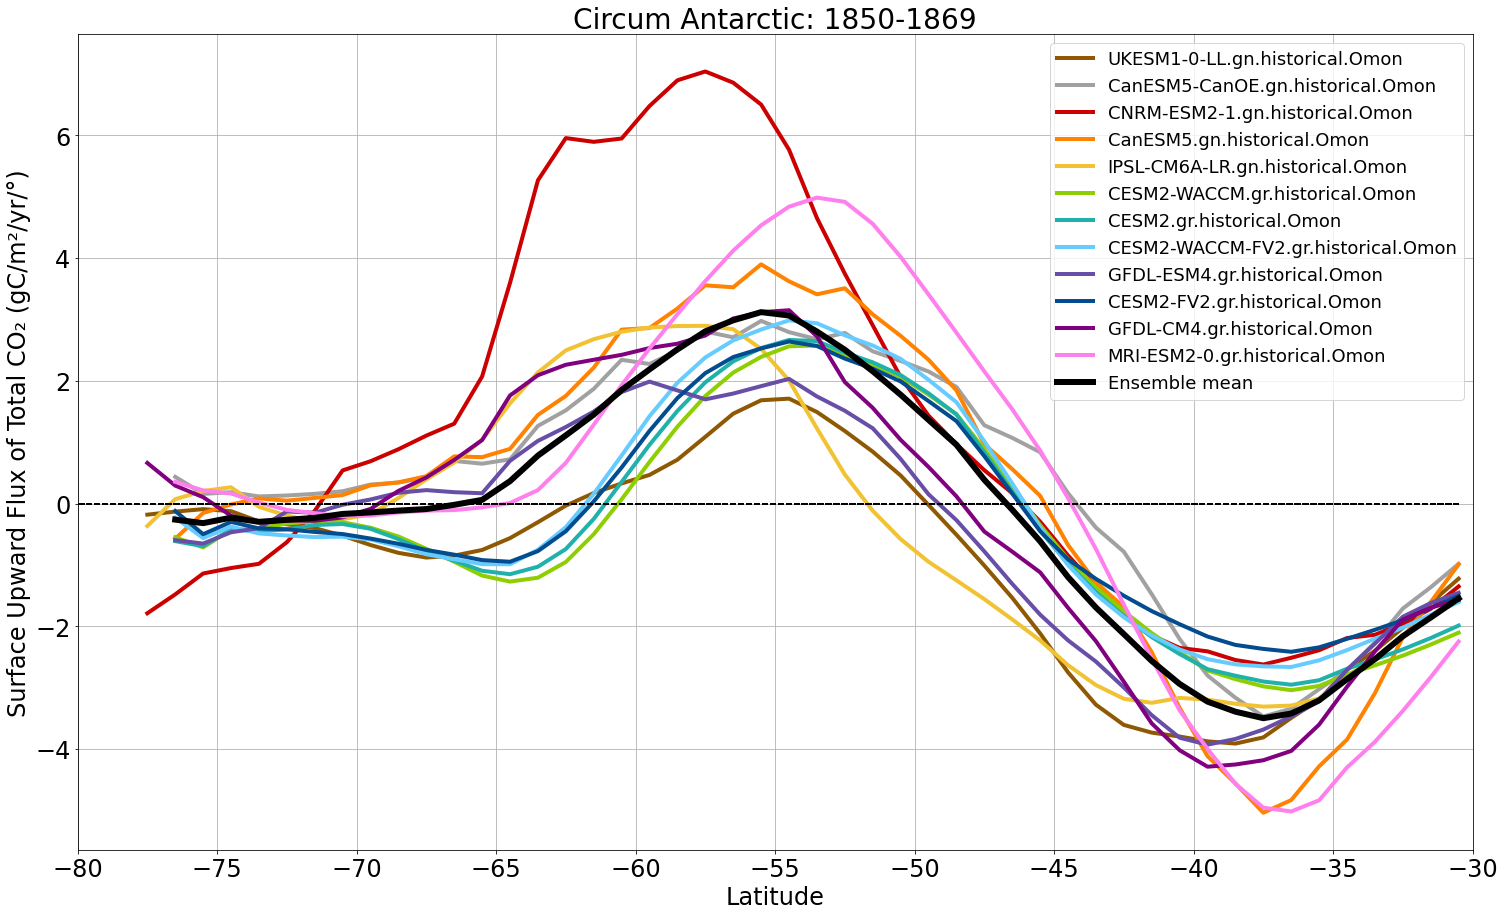

In [26]:
plt.rc('font', size = 24)
plt.rc('axes', titlesize= 24)    
plt.rc('axes', labelsize= 24)
plt.rc('figure', titlesize=24)

temp = {}

conversion = 3.1536e7 * (12/44) * -1
# 3.1536e7 seconds in a year
# 83.3 converts from mol CO2 to gCO2
# 12 converts from CO2 to C

for name, ds in dd.items():

    # sum(fgco2 * A, 'x')/sum(A, 'x')
    # ds = (-1*ds.fgco2*conversion*A).sum('x')/A.sum('x')
    ds = (ds.fgco2*conversion*1e3).weighted(A)
    ds = ds.mean(['x'],keep_attrs=True)
    ar = ds
    
    # put into a temp array so I can eventually take a mean of temp members
    temp[name]=ar
    
# plots the individual models .sel(y = slice(-80, -30))
for name, ds in temp.items():
    plt.plot(ds.y, ds, label = name, lw = 4, **model_kwargs[name])


# take the mean of temp and plot
mn = np.mean(list(temp.values()), axis=0)
plt.plot(ds.y, mn, lw = 6, label = 'Ensemble mean', color = 'black')

# line of y = 0
zr = xr.zeros_like(dd['CESM2-FV2.gr.historical.Omon'].fgco2)
plt.plot(zr.y, zr, linestyle = 'dashed', color = 'black')

# Formatting things
plt.xlabel('Latitude', fontsize = 24)
plt.ylabel('Surface Upward Flux of Total CO\u2082 (gC/m\u00b2/yr/\u00b0)', fontsize = 24)
plt.xlim([-80,-30])
plt.xticks([-80, -75, -70, -65, -60, -55, -50, -45, -40, -35, -30])
plt.grid()
plt.legend(loc='upper right', fontsize = 18)
plt.title('Circum Antarctic: 1850-1869', fontsize = 28)
plt.rcParams["figure.figsize"] = (25,15)

## Total outgassed CO2
Just summing the area integrated flux where it is positive (above)

Summing from 40 to 80 to exclude coast of South America

### So i think since I'm taking total outgas I can just multiply by the area of each grid cell which will give units of TgC/yr

In [29]:
fgco2_sums = {}

for name, ds in dd.items():
    # ds = ds.mean(['x'],keep_attrs=True)
    ds = (ds.fgco2*conversion*A)/1e9
    #GgC/yr
    ds = ds.sel(y = slice(-80, -40))
    # ds = -1*ds.fgco2*conversion
    fgco2_sums[name] = sum(sum(np.where(ds>0, ds, 0)))
    

# sum(res)
fgco2_sums


{'UKESM1-0-LL.gn.historical.Omon': 43.41132877237396,
 'CanESM5-CanOE.gn.historical.Omon': 118.73519327864051,
 'CNRM-ESM2-1.gn.historical.Omon': 218.79004032164812,
 'CanESM5.gn.historical.Omon': 133.14381106942892,
 'IPSL-CM6A-LR.gn.historical.Omon': 89.01338157476857,
 'CESM2-WACCM.gr.historical.Omon': 82.76833900506608,
 'CESM2.gr.historical.Omon': 85.59998923702369,
 'CESM2-WACCM-FV2.gr.historical.Omon': 95.85875357303303,
 'GFDL-ESM4.gr.historical.Omon': 82.03564293589443,
 'CESM2-FV2.gr.historical.Omon': 85.06157219781016,
 'GFDL-CM4.gr.historical.Omon': 121.32868277281523,
 'MRI-ESM2-0.gr.historical.Omon': 158.35605125129223}

In [30]:

clrs = {'UKESM1-0-LL.gn.historical.Omon': '#8f5904',
        'CanESM5-CanOE.gn.historical.Omon': '#a1a1a1',
        'CNRM-ESM2-1.gn.historical.Omon': '#cc0000',
        'CanESM5.gn.historical.Omon':'#ff8200',
        'IPSL-CM6A-LR.gn.historical.Omon': '#f1c232',
        'CESM2-WACCM.gr.historical.Omon': '#8fce00',
        'CESM2.gr.historical.Omon': '#20b2aa',
        'CESM2-WACCM-FV2.gr.historical.Omon': '#66ccff',
        'GFDL-ESM4.gr.historical.Omon': '#674ea7',
        'CESM2-FV2.gr.historical.Omon': '#024c8f',
        'GFDL-CM4.gr.historical.Omon': '#800080',
        'MRI-ESM2-0.gr.historical.Omon': '#ff80ed',
        'Average': 'k'}

clr = ['#8f5904',
        '#a1a1a1',
        '#cc0000',
        '#ff8200',
        '#f1c232',
        '#8fce00',
        '#20b2aa',
        '#66ccff',
        '#674ea7',
        '#024c8f',
        '#800080',
        '#ff80ed',
        'k'
        ]

I think these values are higher than they used to be because I actually converted to gC instead of gCO2

Text(0, 0.5, 'Total CO₂ Outgas (GgC/yr)')

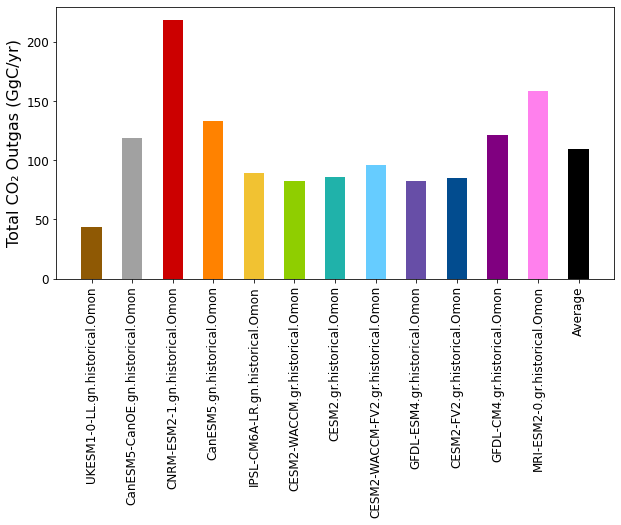

In [31]:
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 16)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=16)

fgco2_sums_avg=list(fgco2_sums.values())
tot_avg = np.mean(fgco2_sums_avg)
fgco2_sums['Average'] = tot_avg

models = list(fgco2_sums.keys())
values = list(fgco2_sums.values())
fig = plt.figure(figsize = (10, 5))
#  Bar plot
plt.bar(models,values,
        width = 0.5, color = clr)
plt.xticks(rotation = 90)

plt.ylabel('Total CO\u2082 Outgas (GgC/yr)')


## Maps

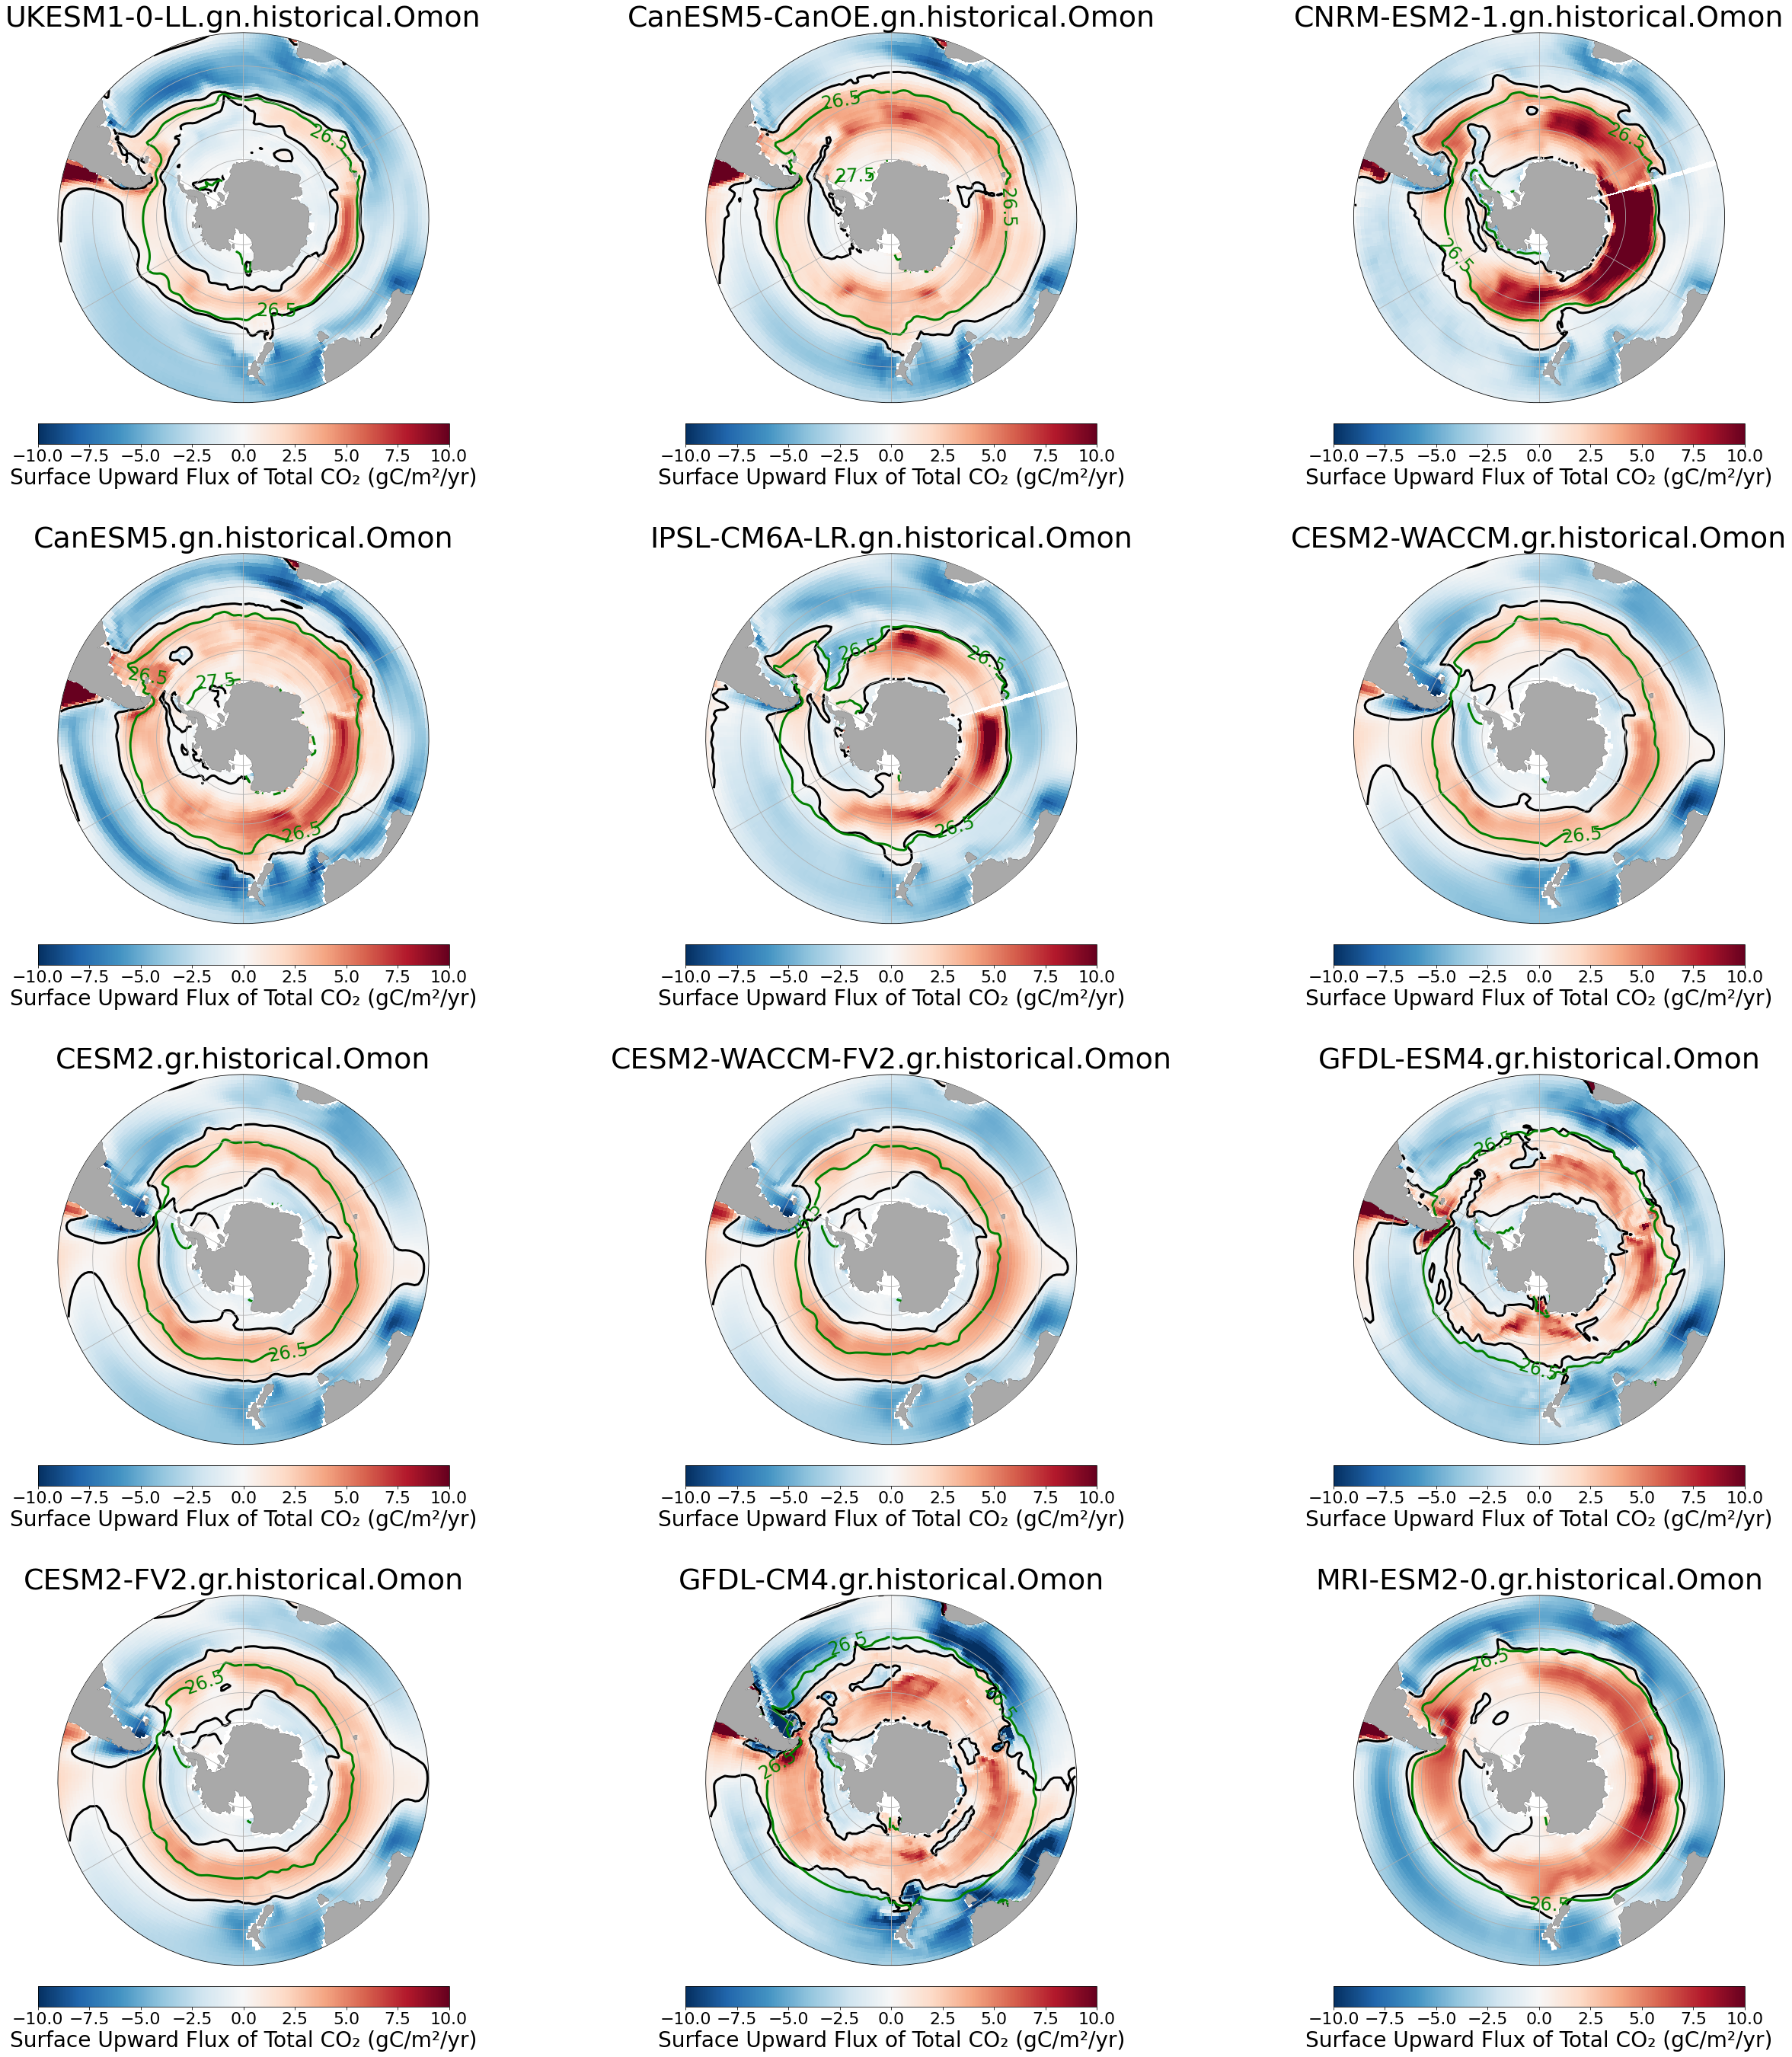

In [41]:
fig, axarr = plt.subplots(nrows = 4, ncols=3, figsize=[40,40], subplot_kw={'projection':ccrs.SouthPolarStereo()})
fig.tight_layout(pad = 12)
crs_plot = ccrs.SouthPolarStereo()
crs_source = ccrs.PlateCarree()

ax_idx = 0 # index for your axes array
for name, ds in dd.items():

    ax = axarr.flat[ax_idx]
    #fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crs_plot})
    ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
    ax.set_extent([-180, 180, -90, -30], crs_source)
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    ax.gridlines()
    ax.coastlines()
    
    title=name
    ax.set_title(title,fontsize=38,pad = 1)
    
    lat = ds['fgco2'].lat.transpose('y','x')
    lon = ds['fgco2'].lon.transpose('y','x')
    X = lon
    Y = lat
    
    # conversion goes to G/m2/year
    
    Z = ds['fgco2']*conversion
    Z2 = ds['sigma0'].isel(lev = 0)
#     rho.assign_coords({'lat': Y})
#     rho.assign_coords({'lon': X})
#     rho = rho.transpose('x','y')
#     rho.assign_coords({'lat': Y})
#     rho.assign_coords({'lon': X})
# #     rho = rho.transpose('y','x')
# #     print(Z)
# #     print(rho)
    
    
    im = ax.pcolormesh(X,Y,Z*1e3,cmap='RdBu_r', transform = crs_source, shading = 'auto', vmin = -10, vmax = 10)
    im2 = ax.contour(X,Y,Z, transform = crs_source, levels=[0],colors='k', linewidths = 3)
    im3 = ax.contour(X, Y, Z2, transform = crs_source, levels = [26.5, 27.5], linewidths = 3, colors = 'g')

    cbar_label = 'Surface Upward Flux of Total CO\u2082 (gC/m\u00b2/yr)'
    cbar = plt.colorbar(im,ax = ax, orientation='horizontal',fraction = 0.05, pad=0.05)
    cbar.set_label(cbar_label, fontsize = 28)
    cbar.ax.tick_params(labelsize=22)
    ax.clabel(im3, inline=1, fontsize=24)
    
    ax_idx += 1


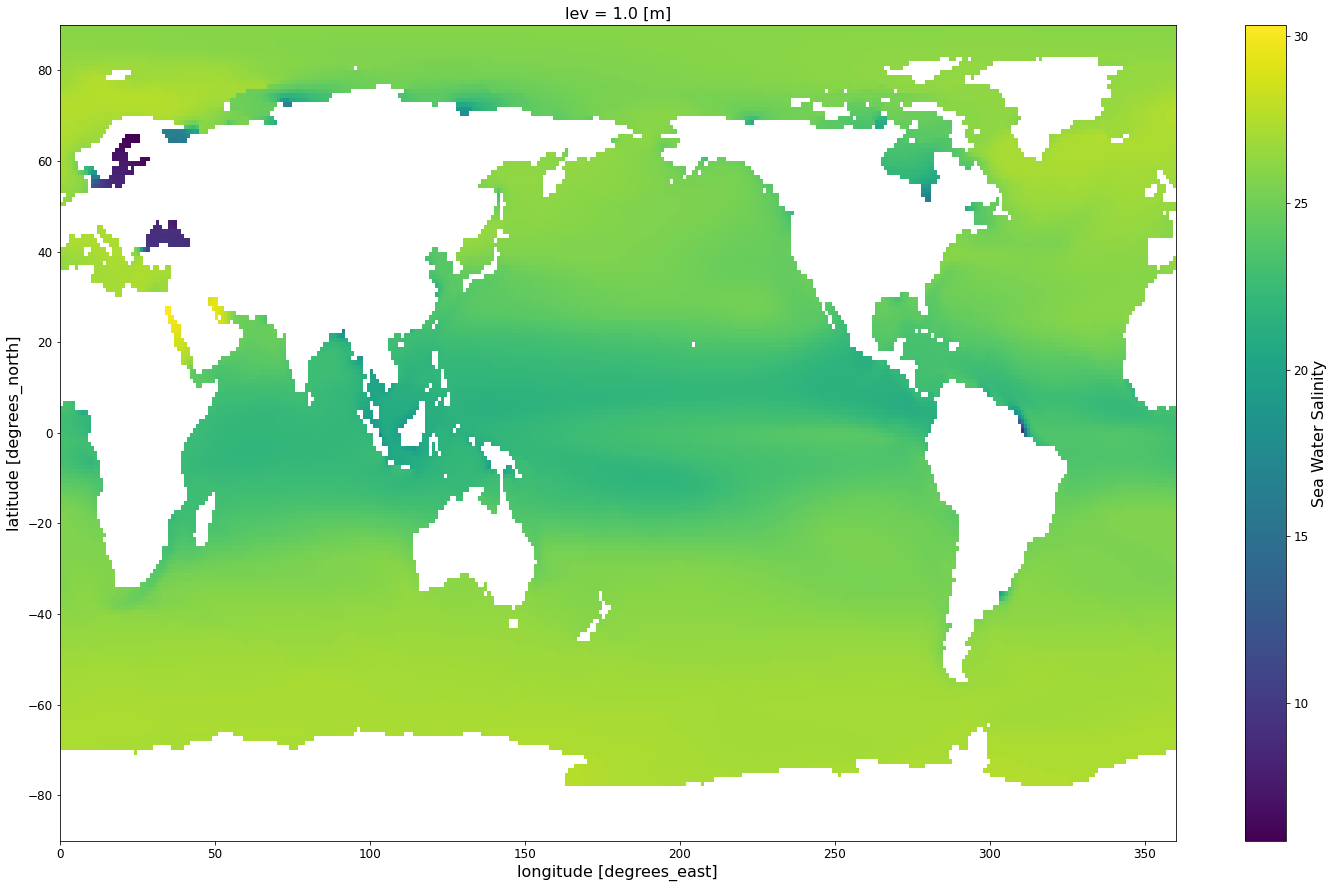

In [25]:
ds['sigma0'].isel(lev = 0).plot()

In [42]:
for name, ds in dd.items():
    ds['area'] = A
    
ds

<xarray.Dataset>
Dimensions:      (y: 60, x: 360, lev: 61, time: 239, bnds: 2)
Coordinates:
  * y            (y) float64 -89.5 -88.5 -87.5 -86.5 ... -33.5 -32.5 -31.5 -30.5
  * lev          (lev) float64 1.0 3.5 6.5 10.0 ... 5.5e+03 6.15e+03 6.525e+03
  * time         (time) datetime64[ns] 1850-01-16T12:00:00 ... 1869-11-16
    time_bounds  (time, bnds) datetime64[ns] dask.array<chunksize=(239, 2), meta=np.ndarray>
    lev_bounds   (lev, bnds) float64 dask.array<chunksize=(61, 2), meta=np.ndarray>
    lon          (y, x) float64 dask.array<chunksize=(60, 360), meta=np.ndarray>
    lat          (y, x) float64 dask.array<chunksize=(60, 360), meta=np.ndarray>
  * x            (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Dimensions without coordinates: bnds
Data variables:
    fgco2        (y, x) float32 dask.array<chunksize=(60, 360), meta=np.ndarray>
    so           (lev, y, x) float32 dask.array<chunksize=(61, 60, 360), meta=np.ndarray>
    dissic       (lev, y, x) float32 dask.array<chunksize=(61, 60, 360), meta=np.ndarray>
    hfds         (y, x) float32 dask.array<chunksize=(60, 360), meta=np.ndarray>
    talk         (lev, y, x) float32 dask.array<chunksize=(61, 60, 360), meta=np.ndarray>
    thetao       (lev, y, x) float32 dask.array<chunksize=(61, 60, 360), meta=np.ndarray>
    p            (lev, y, x) float64 dask.array<chunksize=(61, 60, 360), meta=np.ndarray>
    insitutemp   (lev, y, x) float64 dask.array<chunksize=(61, 60, 360), meta=np.ndarray>
    sigma2       (lev, y, x) float64 dask.array<chunksize=(61, 60, 360), meta=np.ndarray>
    sigma0       (lev, y, x) float64 dask.array<chunksize=(61, 60, 360), meta=np.ndarray>
    area         (y, x) float32 dask.array<chunksize=(60, 360), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

## Outgas intensity
I think this holds up because I checked it with Graeme awhile back

In [43]:
avgs = {}

ax_idx = 0 # index for your axes array
for name, ds in dd.items():
    
    ds = ds.where(ds.fgco2 < 0).sel(y = slice(-80, -40))


    
    # conversion = 3.1536e7 * 83.3
    # 3.1536e7 seconds per year
    # 83.3 mol C per kg -- 12 gC/mol
    
    Z = -1*ds['fgco2']*conversion

    Za = Z*ds.area
    Zasum = Za.sum() 
    
    Atot = ds.area.sum()
    
    avgs[name] = Zasum/Atot


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


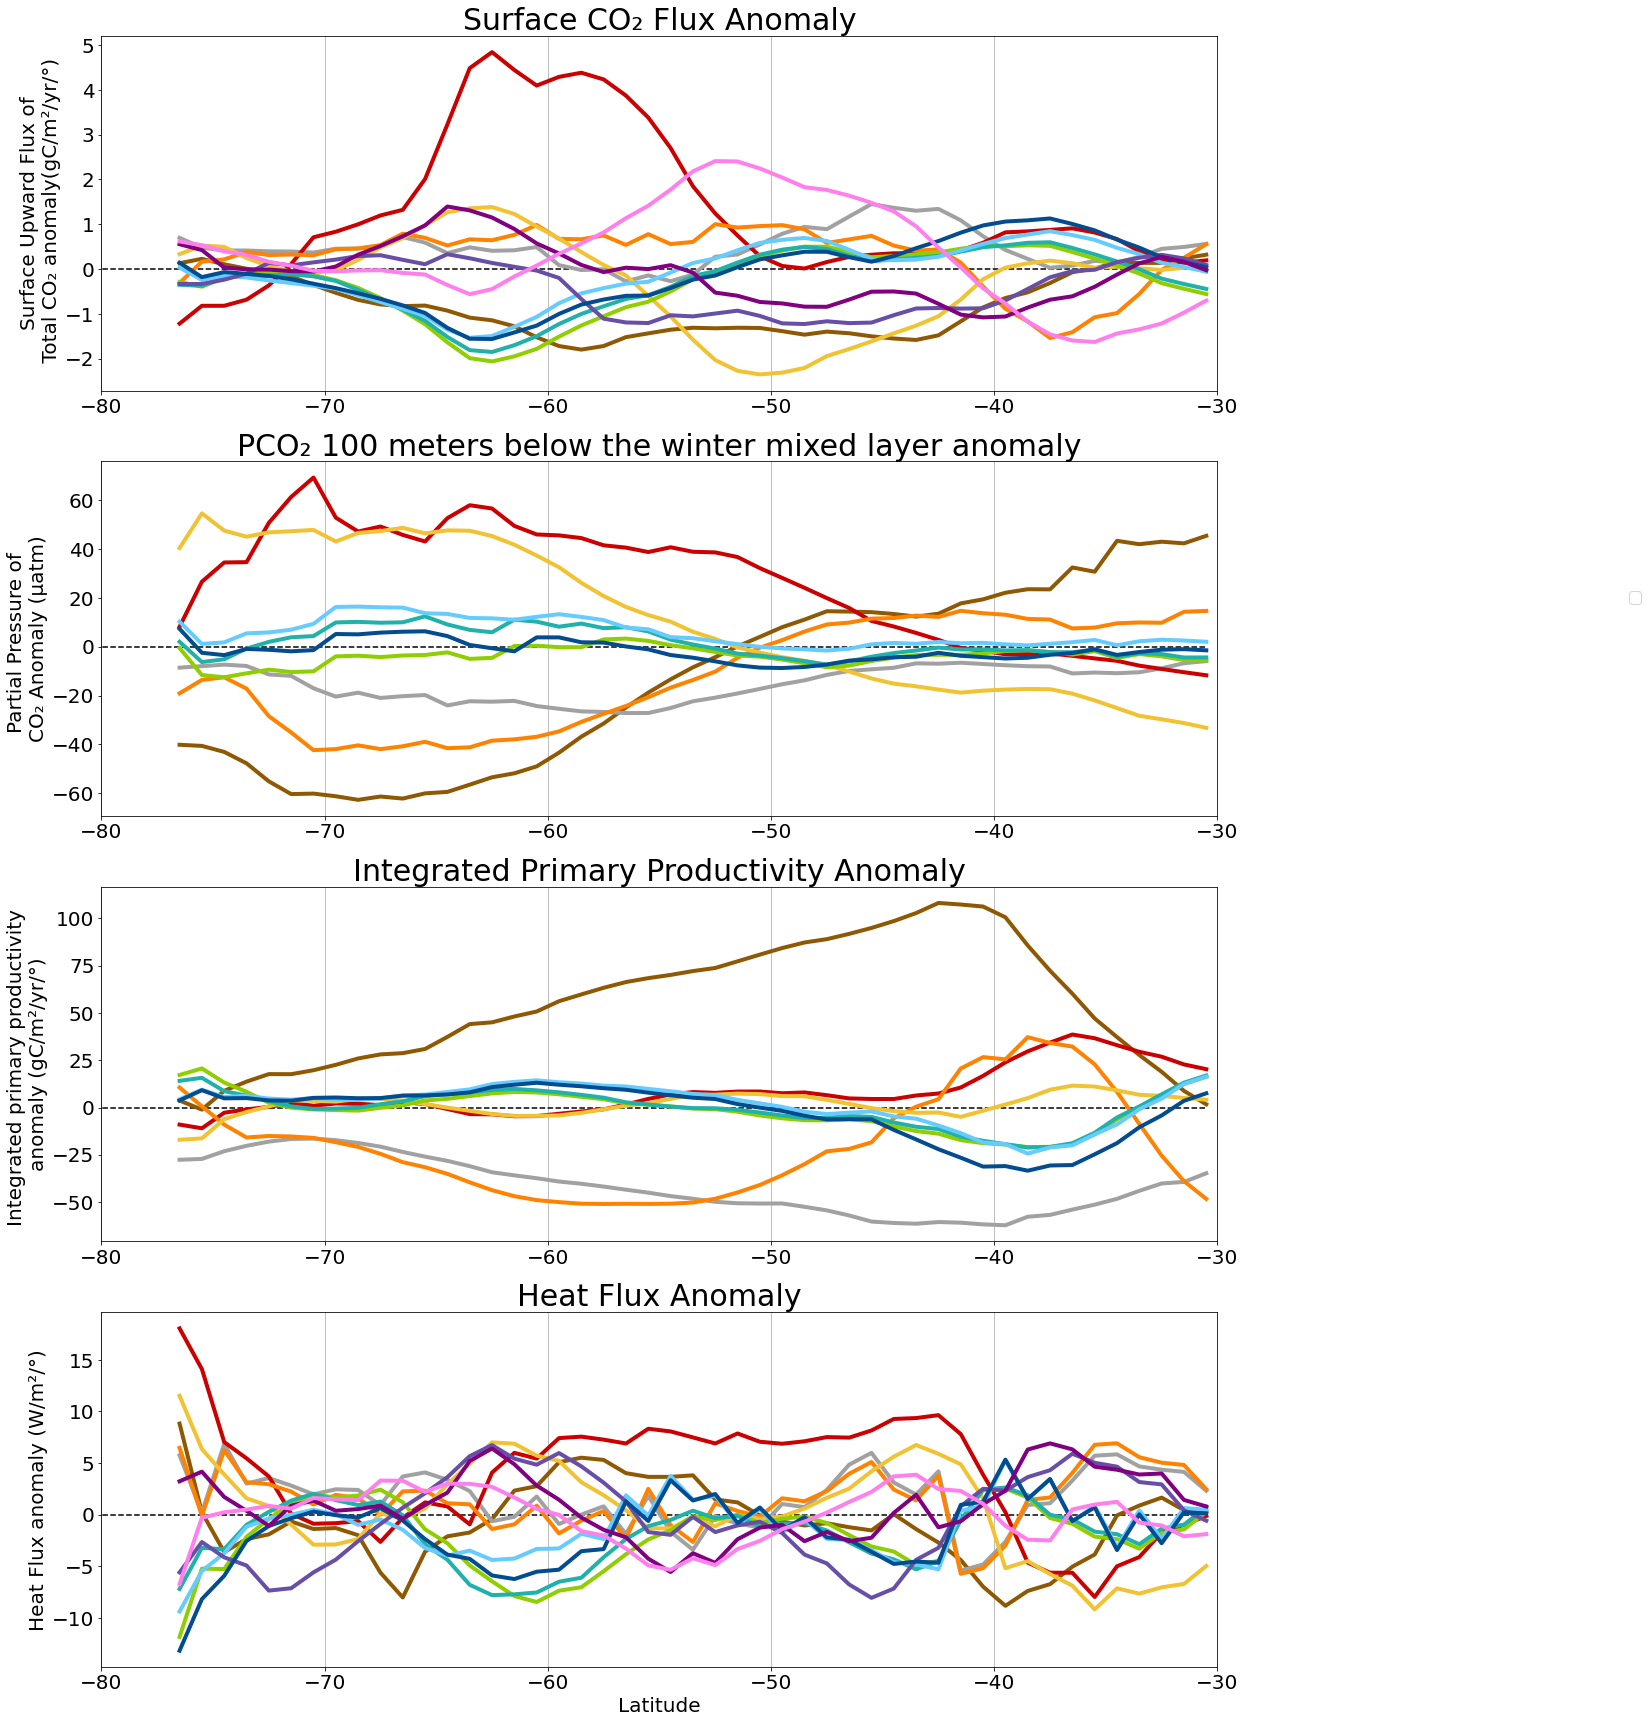

In [75]:
plt.rc('font', size = 20)
plt.rc('axes', titlesize= 20)    
plt.rc('axes', labelsize= 20)
plt.rc('figure', titlesize=20)

fig = plt.figure(figsize=(20, 30)) 
ax_co2 = plt.subplot2grid((4,1), (0, 0), rowspan = 1)
ax_PCO2 = plt.subplot2grid((4,1), (1, 0), rowspan = 1)
ax_intpp = plt.subplot2grid((4,1), (2, 0), rowspan = 1)
ax_hfds = plt.subplot2grid((4,1), (3, 0), rowspan = 1)
# plt.subplots_adjust(hspace = 0.05)
# ax.set_xticklabels([])
conversion = 3.1536e7 * 83.3

temp_co2 = {}
temp_PCO2 = {}
temp_intpp = {}
temp_hfds = {}

for name, ds in dd.items():
    present = ds.data_vars
        
    dr = (ds.fgco2*3.1536e7 * (12/44) * -1*1e3).weighted(A)
    dr = dr.mean(['x'],keep_attrs=True)
    temp_co2[name] = dr
    # ax.plot(dr.y, dr, lw = 4, **model_kwargs[name])
    if 'mlotst' in present:
        d = ds.PCO2_ML.weighted(A)
        d = d.mean('x', keep_attrs = True)
        temp_PCO2[name] = d
        # d = d*A
        # ax2.plot(d.y, d, label = name, lw = 4, **model_kwargs[name])
    if 'intpp' in present:
        d = ds.intpp.weighted(A)
        d = d.mean('x', keep_attrs = True)
        temp_intpp[name] = d
    if 'hfds' in present:
        d = ds.hfds.weighted(A)
        d = d.mean('x', keep_attrs = True)
        temp_hfds[name] = d

mn_CO2 = np.mean(list(temp_co2.values()), axis=0)
mn_PCO2 = np.mean(list(temp_PCO2.values()), axis=0)
mn_intpp = np.mean(list(temp_intpp.values()), axis=0)
mn_hfds = np.mean(list(temp_hfds.values()), axis=0)

zr_CO2 = np.zeros_like(mn_CO2)
ax_co2.plot(ds.y, zr_CO2, linestyle = 'dashed', color = 'black')
zr_PCO2 = np.zeros_like(mn_PCO2)
ax_PCO2.plot(ds.y, zr_PCO2, linestyle = 'dashed', color = 'black')
zr_intpp = np.zeros_like(mn_CO2)
ax_intpp.plot(ds.y, zr_intpp, linestyle = 'dashed', color = 'black')
zr_hfds = np.zeros_like(mn_CO2)
ax_hfds.plot(ds.y, zr_hfds, linestyle = 'dashed', color = 'black')

for name, ds in temp_co2.items():
    ax_co2.plot(ds.y, ds-mn_CO2, lw = 4, **model_kwargs[name])
for name, ds in temp_PCO2.items():
    ax_PCO2.plot(ds.y, ds-mn_PCO2, lw = 4, **model_kwargs[name])
for name, ds in temp_intpp.items():
    ax_intpp.plot(ds.y, ds-mn_intpp, lw = 4, **model_kwargs[name])
for name, ds in temp_hfds.items():
    ax_hfds.plot(ds.y, ds-mn_hfds, lw = 4, **model_kwargs[name])

ax_co2.set_ylabel('Surface Upward Flux of\n Total CO\u2082 anomaly(gC/m\u00b2/yr/\u00b0)')
ax_co2.set_title('Surface CO\u2082 Flux Anomaly', fontsize = 30)
ax_co2.grid(axis = 'x')
ax_co2.set_xlim([-80,-30])

ax_PCO2.set_ylabel('Partial Pressure of \nCO\u2082 Anomaly (\u03BCatm)')
ax_PCO2.set_title('PCO\u2082 100 meters below the winter mixed layer anomaly', fontsize = 30)
ax_PCO2.grid(axis = 'x')
ax_PCO2.set_xlim([-80,-30])

ax_intpp.set_ylabel('Integrated primary productivity \nanomaly (gC/m\u00b2/yr/\u00b0)')
ax_intpp.set_title('Integrated Primary Productivity Anomaly', fontsize = 30)
ax_intpp.grid(axis = 'x')
ax_intpp.set_xlim([-80,-30])

ax_hfds.set_ylabel('Heat Flux anomaly (W/m\u00b2/\u00b0)')
ax_hfds.set_title('Heat Flux Anomaly', fontsize = 30)
ax_hfds.grid(axis = 'x')
ax_hfds.set_xlabel('Latitude')
ax_hfds.set_xlim([-80,-30])


# fig.legend(
# #     bbox_to_anchor=(1.05, 1), 
#     loc='upper', fontsize = 18
# #     , borderaxespad=0.
# )

fig.legend(bbox_to_anchor=(1.2, 0.62), loc='center right', ncol=1, fontsize = 16)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


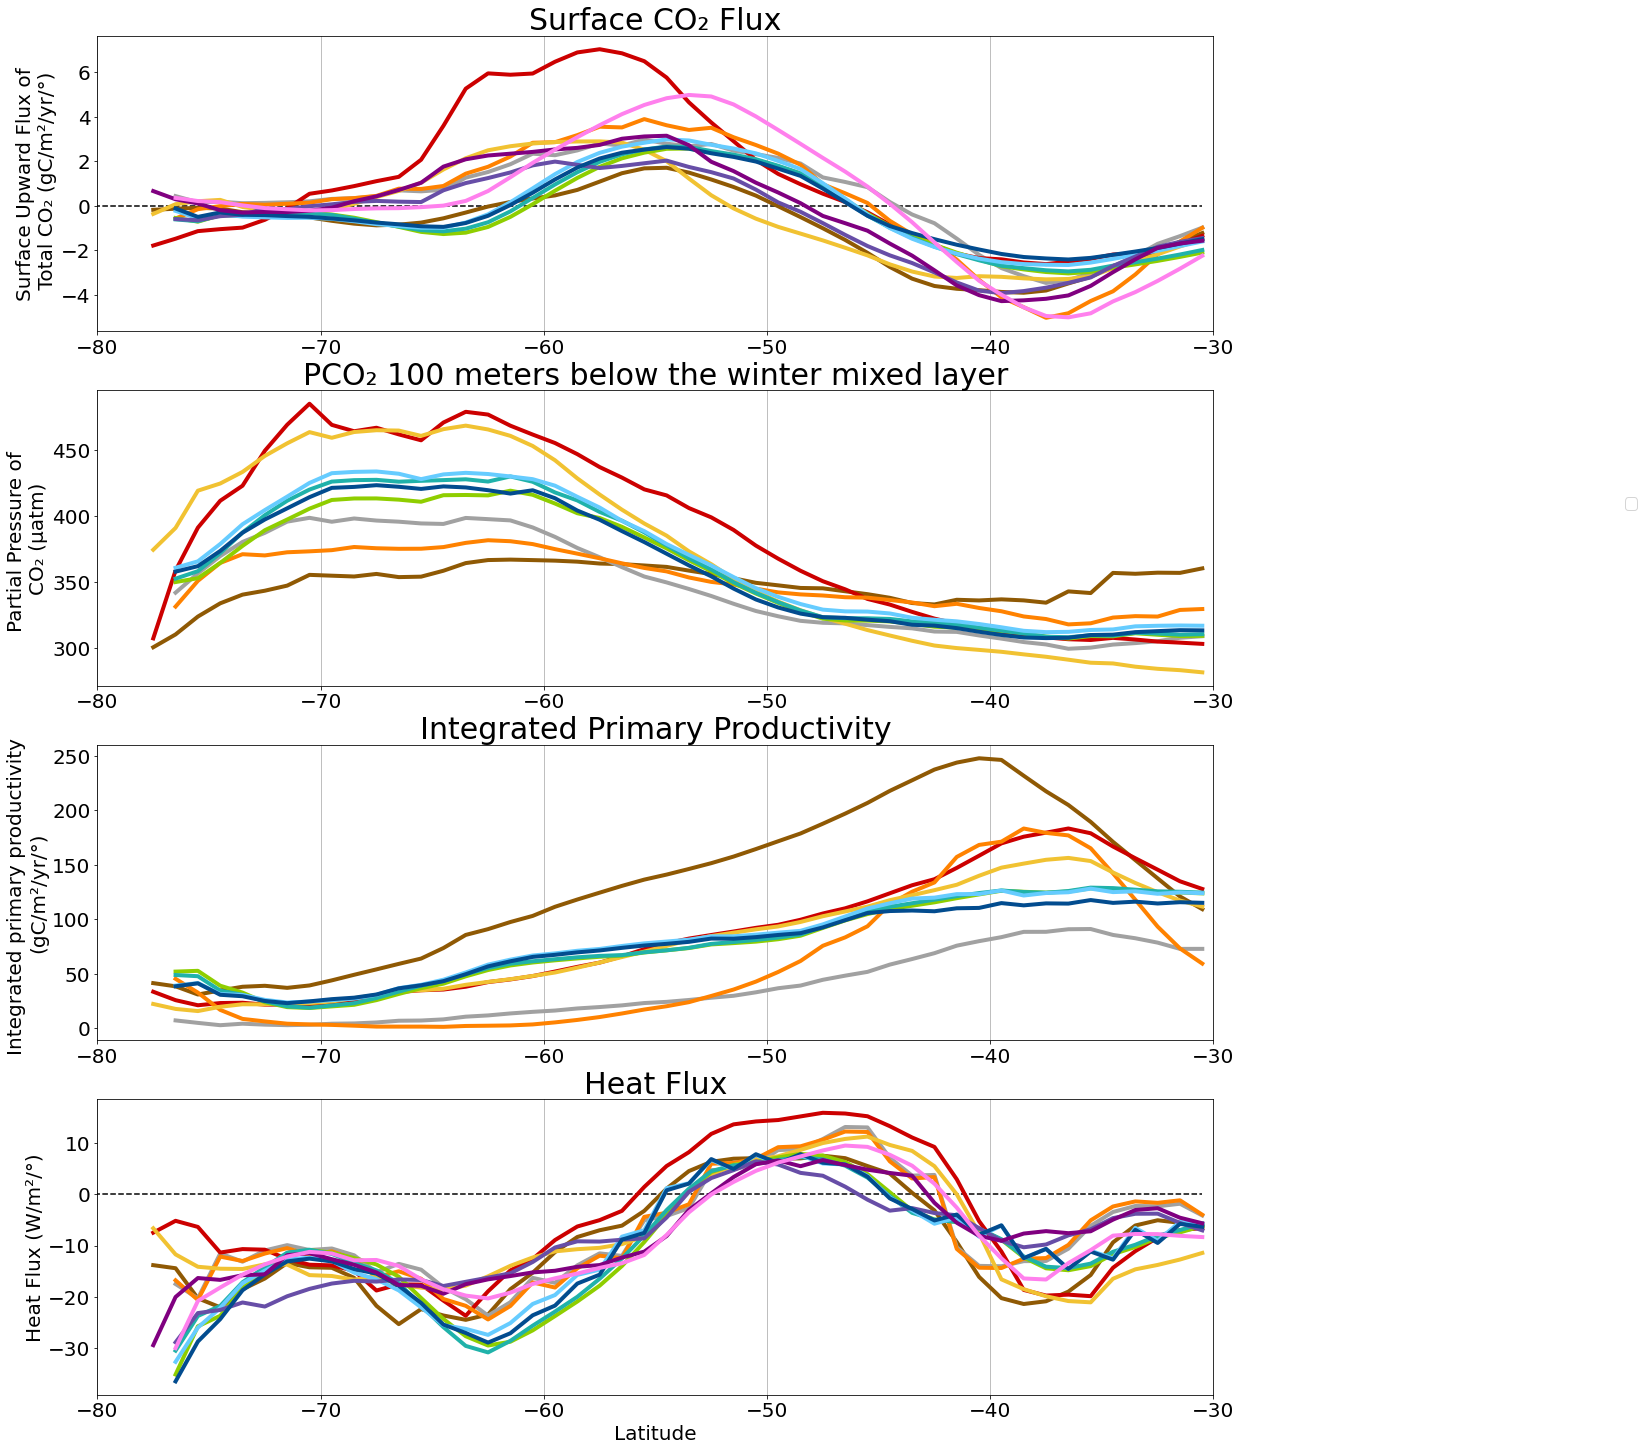

In [76]:
plt.rc('font', size = 20)
plt.rc('axes', titlesize= 20)    
plt.rc('axes', labelsize= 20)
plt.rc('figure', titlesize=20)

fig = plt.figure(figsize=(20, 25)) 
ax_co2 = plt.subplot2grid((4,1), (0, 0), rowspan = 1)
ax_PCO2 = plt.subplot2grid((4,1), (1, 0), rowspan = 1)
ax_intpp = plt.subplot2grid((4,1), (2, 0), rowspan = 1)
ax_hfds = plt.subplot2grid((4,1), (3, 0), rowspan = 1)
# plt.subplots_adjust(hspace = 0.05)
# ax.set_xticklabels([])
conversion = 3.1536e7 * 83.3

temp_co2 = {}
temp_PCO2 = {}
temp_intpp = {}
temp_hfds = {}

for name, ds in dd.items():
    present = ds.data_vars
        
    dr = (ds.fgco2*3.1536e7 * (12/44) * -1).weighted(A)
    dr = dr.mean(['x'],keep_attrs=True)
    temp_co2[name] = dr
    # ax.plot(dr.y, dr, lw = 4, **model_kwargs[name])
    if 'mlotst' in present:
        d = ds.PCO2_ML.weighted(A)
        d = d.mean('x', keep_attrs = True)
        temp_PCO2[name] = d
        # d = d*A
        # ax2.plot(d.y, d, label = name, lw = 4, **model_kwargs[name])
    if 'intpp' in present:
        d = ds.intpp.weighted(A)
        d = d.mean('x', keep_attrs = True)
        temp_intpp[name] = d
    if 'hfds' in present:
        d = ds.hfds.weighted(A)
        d = d.mean('x', keep_attrs = True)
        temp_hfds[name] = d

mn_CO2 = np.mean(list(temp_co2.values()), axis=0)
mn_PCO2 = np.mean(list(temp_PCO2.values()), axis=0)
mn_intpp = np.mean(list(temp_intpp.values()), axis=0)
mn_hfds = np.mean(list(temp_hfds.values()), axis=0)

zr_CO2 = np.zeros_like(mn_CO2)
ax_co2.plot(ds.y, zr_CO2, linestyle = 'dashed', color = 'black')

zr_hfds = np.zeros_like(mn_CO2)
ax_hfds.plot(ds.y, zr_hfds, linestyle = 'dashed', color = 'black')


for name, ds in temp_co2.items():
    ax_co2.plot(ds.y, ds*1e3, lw = 4, **model_kwargs[name])
for name, ds in temp_PCO2.items():
    ax_PCO2.plot(ds.y, ds, lw = 4, **model_kwargs[name])
for name, ds in temp_intpp.items():
    ax_intpp.plot(ds.y, ds, lw = 4, **model_kwargs[name])
for name, ds in temp_hfds.items():
    ax_hfds.plot(ds.y, ds, lw = 4, **model_kwargs[name])

ax_co2.set_ylabel('Surface Upward Flux of\n Total CO\u2082 (gC/m\u00b2/yr/\u00b0)')
ax_co2.set_title('Surface CO\u2082 Flux', fontsize = 30)
ax_co2.grid(axis = 'x')
ax_co2.set_xlim([-80,-30])

ax_PCO2.set_ylabel('Partial Pressure of \nCO\u2082 (\u03BCatm)')
ax_PCO2.set_title('PCO\u2082 100 meters below the winter mixed layer', fontsize = 30)
ax_PCO2.grid(axis = 'x')
ax_PCO2.set_xlim([-80,-30])

ax_intpp.set_ylabel('Integrated primary productivity \n(gC/m\u00b2/yr/\u00b0)')
ax_intpp.set_title('Integrated Primary Productivity', fontsize = 30)
ax_intpp.grid(axis = 'x')
ax_intpp.set_xlim([-80,-30])

ax_hfds.set_ylabel('Heat Flux (W/m\u00b2/\u00b0)')
ax_hfds.set_title('Heat Flux', fontsize = 30)
ax_hfds.grid(axis = 'x')
ax_hfds.set_xlabel('Latitude')
ax_hfds.set_xlim([-80,-30])


# fig.legend(
# #     bbox_to_anchor=(1.05, 1), 
#     loc='upper', fontsize = 18
# #     , borderaxespad=0.
# )

fig.legend(bbox_to_anchor=(1.2, 0.62), loc='center right', ncol=1, fontsize = 16)